<a href="https://colab.research.google.com/github/Viswonathan06/Handwriting-Recognition-System/blob/main/Handwriting_Recognition_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwriting Recognition System







In [ ]:
import os
import cv2
import numpy as np 
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle


In [ ]:
from google.colab import drive
import requests
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Extracting the dataset from the path where it is downloaded or loaded

In [ ]:
#extracting
from zipfile import ZipFile
with ZipFile("/content/gdrive/MyDrive/archive.zip") as f:
    f.extractall()

## Reading the dataset

In [ ]:
data = pd.read_csv("/content/A_Z Handwritten Data/A_Z Handwritten Data.csv").astype('float32')
#show its head
data.head()


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617,0.618,0.619,0.620,0.621,0.622,0.623,0.624,0.625,0.626,0.627,0.628,0.629,0.630,0.631,0.632,0.633,0.634,0.635,0.636,0.637,0.638,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here we rename the first colums as "label" for convenience and we'll see how we use it later to count uniques and separate the dataframe into train and test.

In [ ]:
#rename the class column
data.rename(columns={'0':'label'}, inplace=True)
#show the top 5 rows 
data.head()

,label,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617,0.618,0.619,0.620,0.621,0.622,0.623,0.624,0.625,0.626,0.627,0.628,0.629,0.630,0.631,0.632,0.633,0.634,0.635,0.636,0.637,0.638,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


If we count the number of unique values in the 'label' column, we see there are 26 values, corresponding to 26 alphabets. We are only taking letters into consideration here. 

In [ ]:
data.label.nunique()


26

## Split dataset into train and test

In [ ]:
# Split data to Features X and labels y
X = data.drop('label',axis = 1)
y = data.label
#get the shape of labels and features 
print(f'Features shape is :{X.shape}')
print(f'Shape of the class column is :{y.shape}')
#split into train and test set into 8:2 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Features shape is :(372450, 784)
Shape of the class column is :(372450,)


((297960, 784), (74490, 784), (297960,), (74490,))

## Scaling data

Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [ ]:
# scale data
scaler = MinMaxScaler()
scaler.fit(X_train)
#scaling data 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train[1:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

We then reshape the numpy arrays that we got into known shapes so as to have an idea about the input size of the first layer to our model. 

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 28,28,1)).astype('float32')
X_test = np.reshape(X_test, (X_test.shape[0], 28,28,1)).astype('float32')
print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (297960, 28, 28, 1)
Test data shape:  (74490, 28, 28, 1)


## Convert the labels to categorical values. 
As discussed in preprocessing of datasets, we convert numerical to categorical values in order to classify the values into one of 26 categories.

In [ ]:
y_train = np_utils.to_categorical(y_train,num_classes=26,dtype=int)
y_test = np_utils.to_categorical(y_test,num_classes=26,dtype=int)
y_train.shape,y_test.shape

((297960, 26), (74490, 26))

We then define a dictionary in order to convert numerical to letters during pictorial representation and plot some of the values.




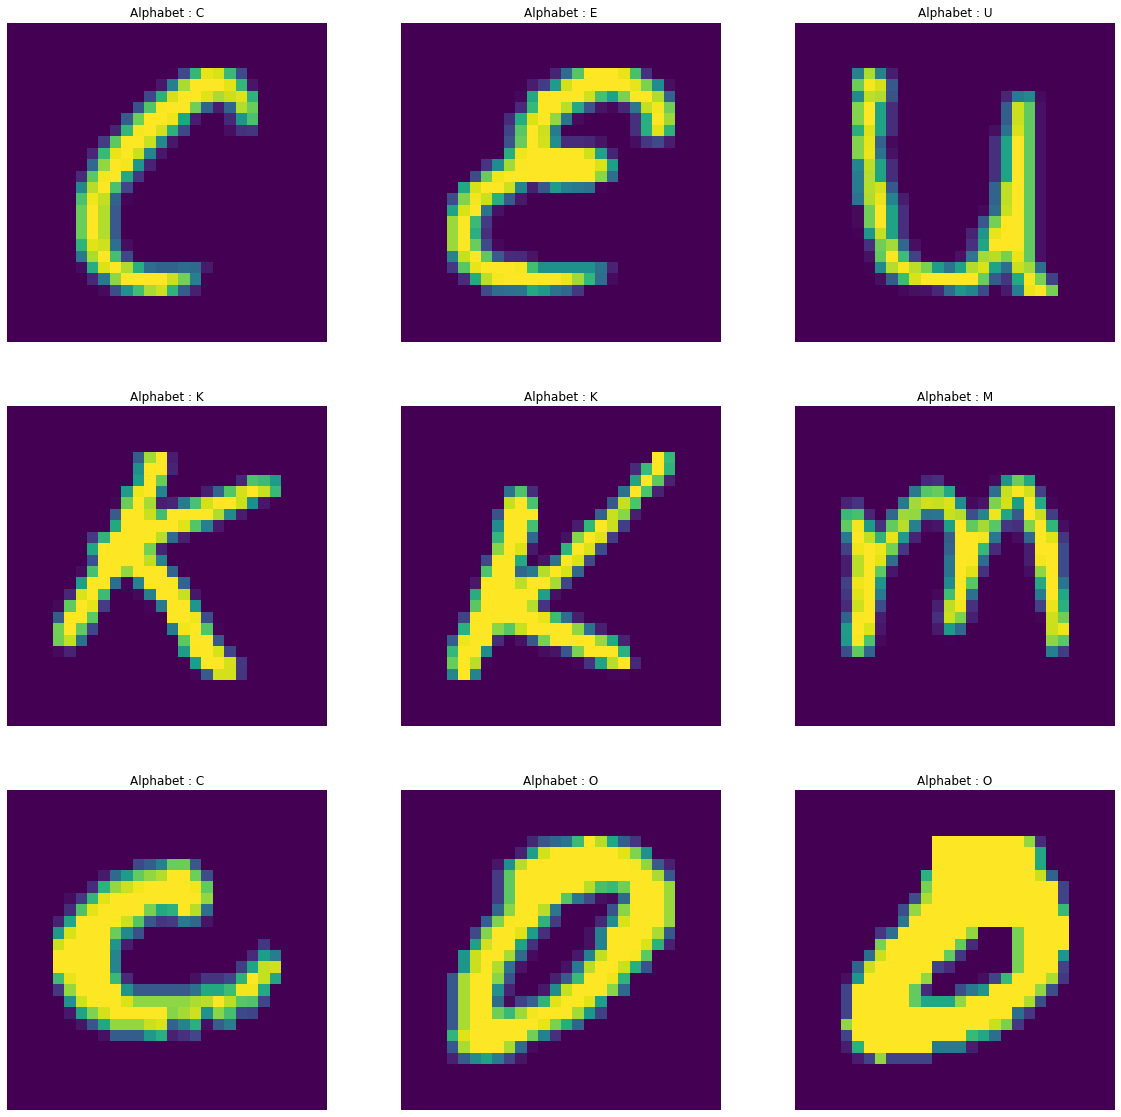

In [ ]:
letters_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',
             7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',
             14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',
             21:'V',22:'W',23:'X', 24:'Y',25:'Z'}
fig, axis = plt.subplots(3, 3, figsize=(20, 20))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train[i].reshape(28,28))
    ax.axis('off')
    ax.set(title = f"Alphabet : {letters_dict[y_train[i].argmax()]}")


## Defining a convolutional neural network model to train 

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
#output layer 
model.add(Dense(26,activation ="softmax"))
#compile 
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 128)       36992     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 64)          73792     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)              

In [ ]:
import time 
start=time.time()
history = model.fit(X_train, y_train, epochs=10,batch_size=128,verbose=2,validation_data = (X_test,y_test))
end=time.time()
print('\n')
print(f'Execution Time :{round((end-start)/60,3)} minutes')

Epoch 1/10
2328/2328 - 60s - loss: 0.1938 - accuracy: 0.9446 - val_loss: 0.0780 - val_accuracy: 0.9796
Epoch 2/10
2328/2328 - 28s - loss: 0.0635 - accuracy: 0.9819 - val_loss: 0.0619 - val_accuracy: 0.9836
Epoch 3/10
2328/2328 - 28s - loss: 0.0483 - accuracy: 0.9862 - val_loss: 0.0525 - val_accuracy: 0.9864
Epoch 4/10
2328/2328 - 25s - loss: 0.0372 - accuracy: 0.9891 - val_loss: 0.0506 - val_accuracy: 0.9884
Epoch 5/10
2328/2328 - 25s - loss: 0.0302 - accuracy: 0.9909 - val_loss: 0.0448 - val_accuracy: 0.9894
Epoch 6/10
2328/2328 - 25s - loss: 0.0238 - accuracy: 0.9928 - val_loss: 0.0525 - val_accuracy: 0.9873
Epoch 7/10
2328/2328 - 28s - loss: 0.0204 - accuracy: 0.9938 - val_loss: 0.0429 - val_accuracy: 0.9912
Epoch 8/10
2328/2328 - 28s - loss: 0.0171 - accuracy: 0.9945 - val_loss: 0.0505 - val_accuracy: 0.9895
Epoch 9/10
2328/2328 - 25s - loss: 0.0155 - accuracy: 0.9951 - val_loss: 0.0495 - val_accuracy: 0.9910
Epoch 10/10
2328/2328 - 25s - loss: 0.0133 - accuracy: 0.9956 - val_loss:

In [ ]:
final_accuracies =model.evaluate(X_test,y_test,verbose=0)
print('Validation Loss : {:.2f}'.format(final_accuracies[0]))
print('Validation Accuracy: {:.2f}'.format(final_accuracies[1]))

Validation Loss : 0.05
Validation Accuracy: 0.99


Text(0.5, 0, 'epochs')

<Figure size 432x288 with 0 Axes>

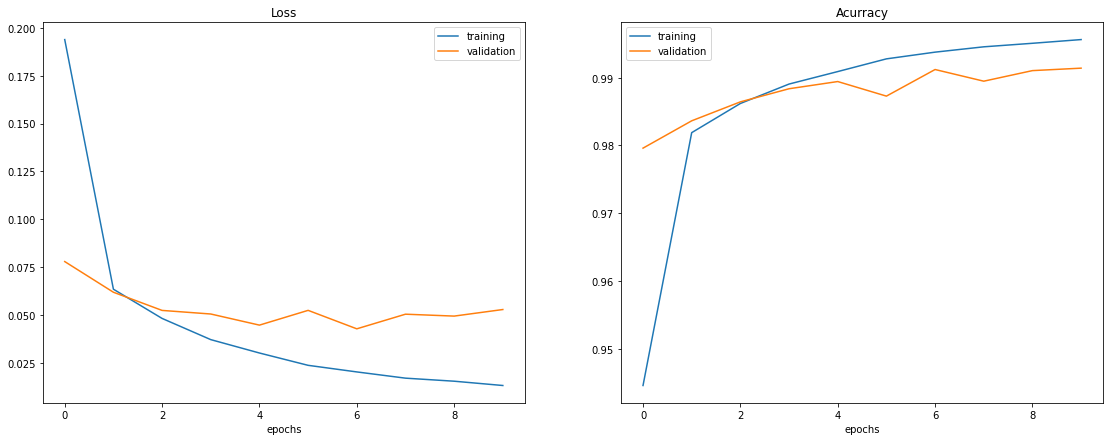

In [ ]:
# Plot training loss vs validation loss 
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,7))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['training','validation'])
ax1.set_title('Loss')
ax1.set_xlabel('epochs')
## plot training accuracy vs validation accuracy 
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['training','validation'])
ax2.set_title('Acurracy')
ax2.set_xlabel('epochs')

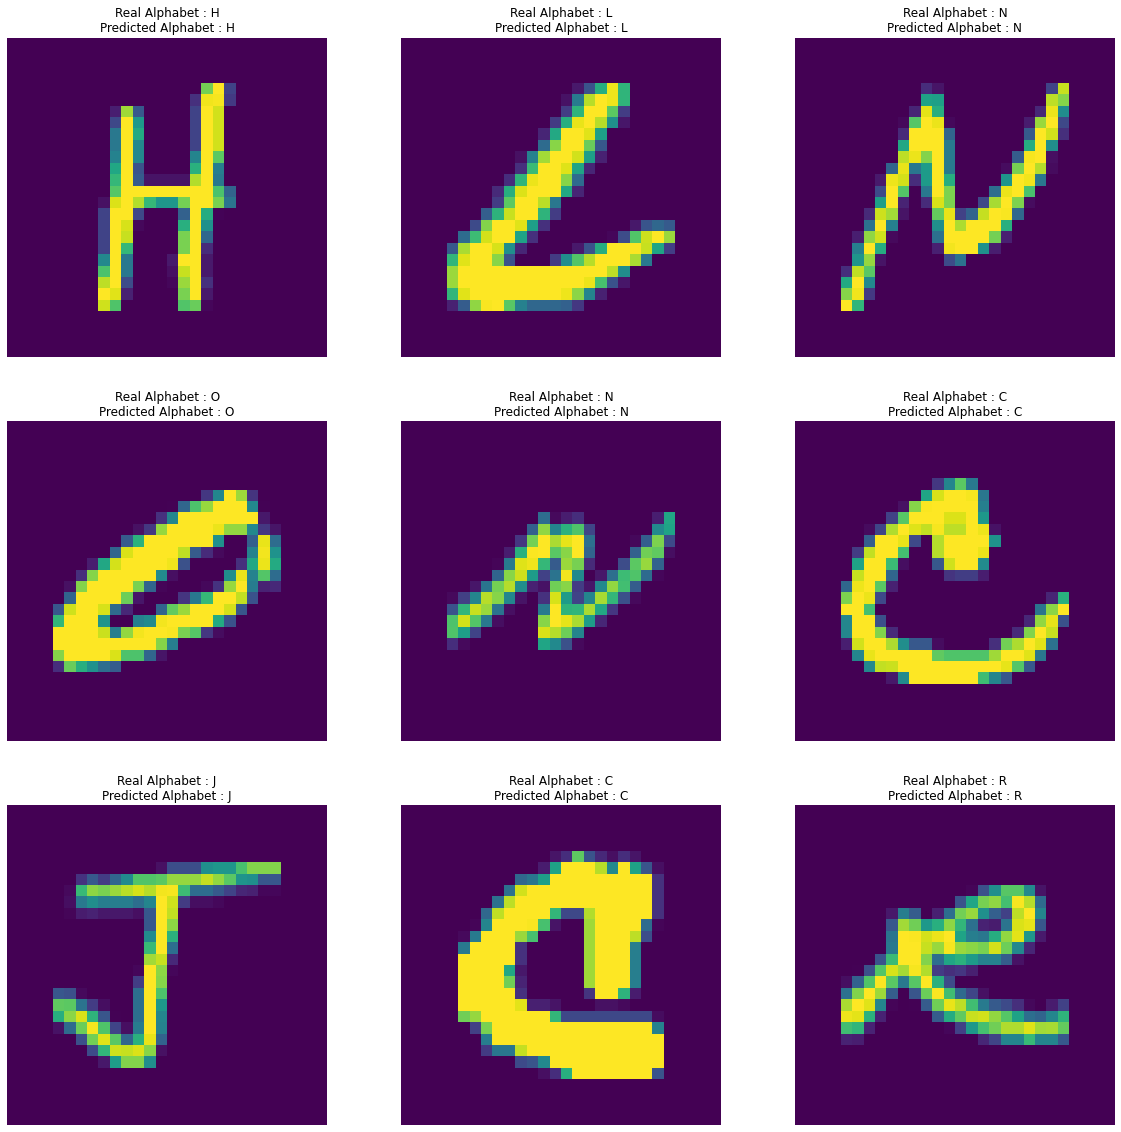

In [ ]:
preds = model.predict(X_test)
X_test_ = X_test.reshape(X_test.shape[0], 28, 28)
fig, axis = plt.subplots(3, 3, figsize=(20, 20))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test_[i])
    ax.axis('off')
    ax.set(title = f"Real Alphabet : {letters_dict[y_test[i].argmax()]}\nPredicted Alphabet : {letters_dict[preds[i].argmax()]}");



In [ ]:
predicted_values = [np.argmax(y, axis=None, out=None) for y in preds]
#get the alphabets using letters dictionnary 
predicted_alphabets =[letters_dict[i] for i in predicted_values]
#Reverse y_test from one hot encoder to an array 
test_labels = [np.argmax(y, axis=None, out=None) for y in y_test]
test_alphabets = [letters_dict[i] for i in test_labels]
# create a submission dataframe 
submission = pd.DataFrame({'Real Alphabet':test_alphabets,'Predicted Aplhabet':predicted_alphabets })
# save to a csv file 
submission.to_csv('submission.csv', index=False)
print(" Submission  successfully saved!")
submission.sample(10)


 Submission  successfully saved!


,Real Alphabet,Predicted Aplhabet
63690,O,O
16461,P,P
25365,U,U
9574,O,O
15833,J,J
3538,G,G
58788,U,U
73341,S,S
10657,N,N
11390,H,H
